***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [8. Calibration ](8_0_introduction.ipynb)
    * Previous: [8. Calibration](8_0_introduction.ipynb)
    * Next: [8.2 1GC calibration](8_2_1gc.ipynb)

***

#### Format status:

* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : LF: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : NC: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : RF: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : HF: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : GM: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : CC: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : CL: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : ST: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : FN: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : TC: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : SP: 06-02-2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : XX: 06-02-2017

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
from scipy import optimize
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
HTML('../style/code_toggle.html')

## 8.1 Calibration as a Least Squares Problem <a id='cal:sec:cal_ls'></a> <!--\label{cal:sec:cal_ls}-->

In this section we discuss the procedure that is generally used in practice to perform calibration. We will use the unpolarized RIME in this section instead of the full-polarized RIME (see [$\S$ 7 &#10142;](../7_Observing_Systems/7_0_introduction.ipynb)). It provides us with a much simpler framework with which we can grasp the basics of calibration. Moreover, we assume for the sake of simplicity that the observed data are only corrupted by the instrument's antenna gains. This assumption results in a idealised treatment as there are many other factors that do in fact corrupt radio interferometric data (see [$\S$ 7 &#10142;](../7_Observing_Systems/7_0_introduction.ipynb)).

The unpolarized RIME is given by the following:

<p class=conclusion>
  <font size=4> <b>Unpolarized RIME</b></font>
  <br>
\begin{equation}
d_{pq}(t) = g_p(t) g_q^*(t) \tilde{d}_{pq}(t) + \epsilon_{pq}(t),
\end{equation}
</p>

where $d_{pq}(t)$ and $\tilde{d}_{pq}(t)$ denote the corrupted observed and uncorrupted visibility at time $t$ associated with baseline $pq$. Moreover, the factors $g_p$ and $g_q$
denote the complex gain of antenna $p$ and $q$. The term $\epsilon_{pq}$ is a zero mean (Gaussian)
noise term, representing thermal noise.

We begin this section by generating the $uv$-tracks of a fictitious instrument in [$\S$ 8.1.1 &#10549;](#cal:sec:uv)<!--\ref{cal:sec:uv}-->. In [$\S$ 8.1.2 &#10549;](#cal:sec:RIME_un)<!--\ref{cal:sec:RIME_un}--> we phrase the calibration problem (for the antenna gains) as a least squares minimization problem. Then in [$\S$ 8.1.3 &#10549;](#cal:sec:sim)<!--\ref{cal:sec:sim}--> we simulate "realistic" visibility data for the $uv$-tracks by including gain errors and adding noise to the resulting visibilities (similar to adding noise to a simple sinusoid as seen in [$\S$ 2.11 &#10142;](../2_Mathematical_Groundwork/2_11_least_squares.ipynb)). We then vectorize the problem in [$\S$ 8.1.4 &#10549;](#cal:sec:LM)<!--\ref{cal:sec:LM}-->, enabling us to use the built in `scipy` *Levenberg-Marquardt* algorithm to calibrate the data produced in [$\S$ 8.1.3 &#10549;](#cal:sec:sim)<!--\ref{cal:sec:sim}-->. We implement the aforementioned steps via a wrapper ipython function called `create_G_LM`. We finish [$\S$ 8.1.4 &#10549;](#cal:sec:LM)<!--\ref{cal:sec:LM}--> by using `create_G_LM` to estimate the antenna gains corrupting the simulated data we produced in [$\S$ 8.1.3 &#10549;](#cal:sec:sim)<!--\ref{cal:sec:sim}-->. The estimated antenna gains are then used to correct the corrupted data in [$\S$ 8.1.5 &#10549;](#cal:sec:cor)<!--\ref{cal:sec:cor}-->.

### 8.1.1 Creating $uv$-Tracks: East-West Interferometer <a id='cal:sec:uv'></a> <!--\label{cal:sec:uv}-->

We know from [$\S$ 4.4.1.B.3 &#10142;](../4_Visibility_Space/4_5_1_uv_coverage_uv_tracks.ipynb#vis:sec:ew) that when we work with an east-west interferometer things simplify to a large degree. Firstly: $XYZ = [0~|\mathbf{b}|~0]^T$, where $|\mathbf{b}|$ is the baseline length.

Moreover, we have that:

<p class=conclusion>
  <font size=4> <b>$uv$-Coverage of an EW-array (8.1)</b></font>
  <br>
\begin{eqnarray}
\\
u &=&| \mathbf{b}|\cos H\\
v &=& |\mathbf{b}|\sin H \sin \delta,
\end{eqnarray}
</p>
<a id='cal:eq:uv_cov'></a> <!--\label{cal:eq:uv_cov}-->

where $H$ is the hour angle of the field center and $\delta$ its declination. In this section we will be plotting the $uv$-coverage of a three element east-west interferometer.
The ENU layout of a simple interferometer is given below. Note that $|\mathbf{b}|$ is measured in wavelengths.

Now consider an array made up of three antennas situated at 0, 100, 200 meters east of
the array center as shown in the code fragment below.

lam =  0.21428571428571427
b [wavelengths] =  [ 466.66666667  933.33333333 1400.        ]


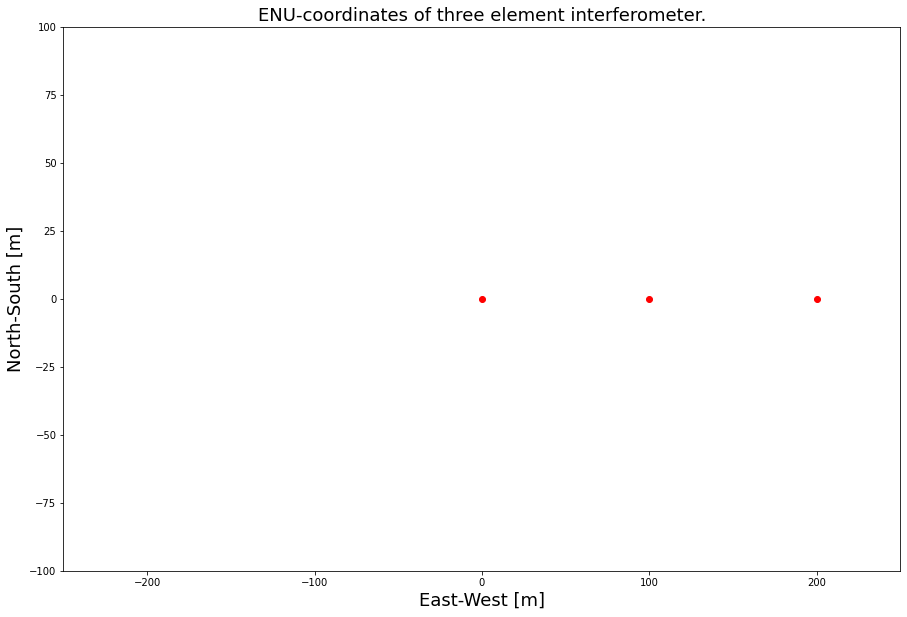

In [4]:
lam = 3e8/1.4e9 #observational wavelenth
print("lam = ",lam)
b = np.array([100,200,300])/lam
print("b [wavelengths] = ",b)
plt.plot(np.array([0,100,200]),np.array([0,0,0]),'ro')
plt.xlim([-250,250])
plt.ylim([-100,100])
plt.xlabel("East-West [m]", fontsize=18)
plt.ylabel("North-South [m]", fontsize=18)
plt.title("ENU-coordinates of three element interferometer.", fontsize=18)
plt.show()

**Figure 8.1.1**: <span style="background-color:cyan">AJR:NC: This figure needs a caption</span>

We first need to set the hour angle range of our observation and the declination of our field center. 

In [5]:
H = np.linspace(-6,6,600)*(np.pi/12) #Hour angle in radians
delta = 60*(np.pi/180) #Declination in radians

Our hour angle range is from -6h to 6h, and our declination is set to $60^{\circ}$.

As the earth rotates the antennas trace out $uv$-tracks (ellipses) as shown in the code fragment below, where the red tracks are due to baseline $pq$ and blue tracks are due to baseline $qp$. We can construct these $uv$-tracks by using [Eq. 8.1 &#10549;](#cal:eq:uv_cov)<!--\ref{cal:eq:uv_cov}-->. 

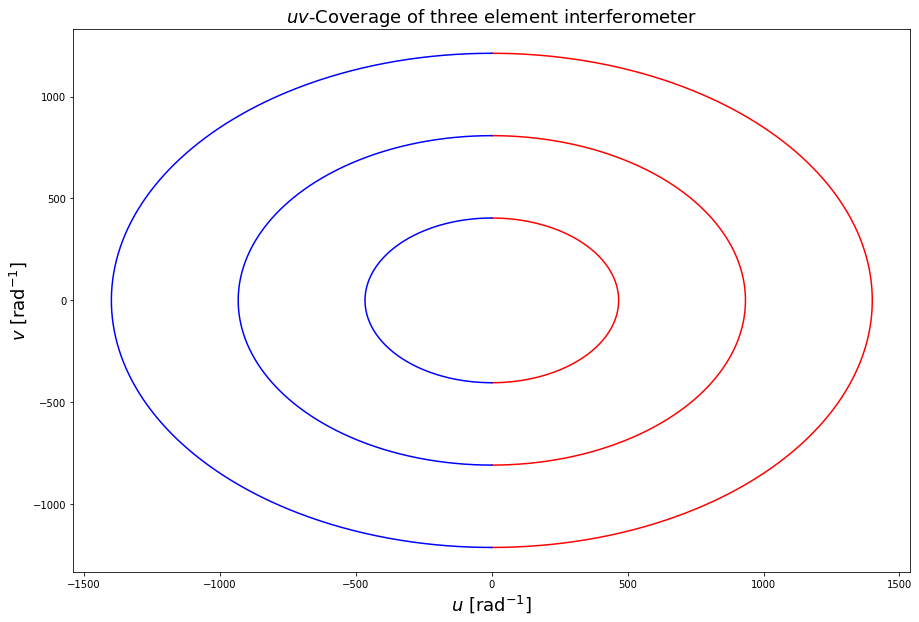

In [6]:
u = np.zeros((len(b),len(H)))
v = np.zeros((len(b),len(H)))
for k in range(len(b)):
    u[k,:] = b[k]*np.cos(H)
    v[k,:] = b[k]*np.sin(H)*np.sin(delta)
    plt.plot(u[k,:],v[k,:],"r")
    plt.plot(-u[k,:],-v[k,:],"b")
plt.xlabel("$u$ [rad$^{-1}$]", fontsize=18)
plt.ylabel("$v$ [rad$^{-1}$]", fontsize=18)
plt.title("$uv$-Coverage of three element interferometer", fontsize=18)
plt.show()

**Figure 8.1.2**: <span style="background-color:cyan">AJR:NC: This figure needs a caption</span>

We can also pack the $uv$-coverage into a 2D-matrix. We denote the rows of this matrix with $p$ and the columns with $q$. The $pq$-th entry denotes the $uv$-track associated with baseline $pq$. The reason for packing the visibilities into a 2D structure will become apparent in [Sec. 8.1.2 &#10549;](#cal:sec:RIME_un)<!--\ref{cal:sec:RIME_un}-->.

In [7]:
u_m = np.zeros((len(b),len(b),len(H)))
v_m = np.zeros((len(b),len(b),len(H)))

u_m[0,1,:] = u[0,:] #the first two entries denote p and q and the third index denotes time
u_m[1,2,:] = u[1,:]
u_m[0,2,:] = u[2,:]

v_m[0,1,:] = v[0,:]
v_m[1,2,:] = v[1,:]
v_m[0,2,:] = v[2,:]

### 8.1.2. Unpolarized Calibration <a id='cal:sec:RIME_un'></a> <!--\label{cal:sec:RIME_un}-->

As explained in [$\S$ 7.2 &#10142;](../7_Observing_Systems/7_2_rime.ipynb) the RIME assumes that our observed signal is polarized. For the sake
of simplicity, however, we will now introduce the calibration problem with the underlying assumption that the observed signal is unpolarized. Unpolarized calibration is achieved by solving the following minimization problem:
<p class=conclusion>
  <font size=4> <b>Unpolarized Calibration</b></font>
  <br>
\begin{equation}
\min_{\boldsymbol{\mathcal{G}}} \left \| \boldsymbol{\mathcal{D}} - \boldsymbol{\mathcal{G}}\boldsymbol{\mathcal{M}}\boldsymbol{\mathcal{G}}^H \right \|,
\end{equation}
</p>

where
* $\boldsymbol{\mathcal{D}}$ is the *observed visibility matrix*. Each entry, which we denote by $d_{pq}$, represents the visibility measured by the baseline formed by antennas $p$ and $q$.
* $\boldsymbol{\mathcal{M}}$ is the *model visibility matrix*. The entry $m_{pq}$ of $\boldsymbol{\mathcal{M}}$ denotes a true or model visibility which was created with the calibration sky model and a $uv$-point on the $uv$-track associated with baseline $pq$.
* $\boldsymbol{\mathcal{G}} = \textrm{diag}(\mathbf{g})$ is the *antenna gain matrix*, where $\mathbf{g}=[g_1,g_2,\cdots,g_N]^T$ denotes the *antenna gain vector*. The operator $\textrm{diag}(\cdot)$ forms a diagonal matrix from a vector by putting the elements of the vector on the main diagonal. The vector $\mathbf{g}$ represents the instrumental response of the antennas, i.e. the complex antenna gains. These antenna gains are chosen in such a way that they minimize the difference between the observed and model visibilities. 
* $\boldsymbol{\mathcal{G}}\boldsymbol{\mathcal{M}}\boldsymbol{\mathcal{G}}^H$ is the *predicted visibility matrix*. This matrix contains the model visibilities after the antenna gains have been applied to them. 

The superscript $(\cdot)^H$ denotes the Hermitian or conjugate transpose and $\left \| \cdot \right \|$ denotes the norm used. Most calibration algorithms use the Frobenius norm for matrices and the 2-norm or Euclidean norm for vectors, thus treating calibration as a least squares problem.<br><br> 
<div class=warn>
<b>Warning:</b> Do not get confused with the polarized and unpolarized RIME. We use 
the notation $\mathbf{V}_{pq}\in\mathbb{C}^{2\times 2}$ to denote the observed correlation matrix corresponding to the antenna feeds $XX,YY,XY$ and $YX$ of antenna $p$ and $q$. We use the notation $\boldsymbol{\mathcal{D}}\in\mathbb{C}^{N\times N}$ to denote the unpolarized observed visibility matrix which contains the observed scalar visibilities of all the antenna pairs. 
</div><br><br>

<div class=advice>
<b>Advice:</b> The unpolarized calibration equation above is equivalent to the following more familiar form: $\min_{\boldsymbol{g}}\sum_{pq}\left|d_{pq}-g_pg_q^*m_{pq}\right|^2$.  
</div><br>

### 8.1.3. Creating an Unpolarized Visibility Matrix (`create_vis_mat`) <a id='cal:sec:sim'></a> <!--\label{cal:sec:sim}-->

In this section we present a function that allows us to create the observed visibility matrix $\boldsymbol{\mathcal{D}}$ and 
the model visibility matrix $\boldsymbol{\mathcal{M}}$. The function employs three separate 
steps to produce a visibility matrix, namely:

* We first take the Fourier transform of the sky model and then sample the result using the 
sampling function (i.e. $uv$-coverage). The sky model can only consist of point sources. Mathematically we may represent our sky model as $I(l,m) = \sum_k A_k\delta(l-l_k,m-m_k)$, where $A_k$ denotes the flux of the $k$-th source and $(l_k,m_k)$ denotes the direction cosine position vector that is associated with the $k$-th source. We then have that
$V(u,v) = \mathscr{F}\{I(l,m)\} = A_k e^{-2\pi \imath l_k u + m_k v}$, where $\mathscr{F}\{\cdot\}$ denotes the Fourier transform of its operand. This result stems from the fact that the Fourier transform of a delta function is a complex exponential. If we now apply the sampling function we finally obtain $V_{pq}(u_{pq},v_{pq}) = A_k e^{-2\pi \imath l_k u_{pq} + m_k v_{pq}}$. We now use $V_{pq}$ to construct a 2D model visibility matrix. The sky model is passed to the function via the variable `point_sources`. The sampling function is passed in via `u_m` and `v_m`. 
* We then corrupt the visibilities with the antenna gains that were passed into the function via `g`. We use `g` to construct $\boldsymbol{\mathcal{G}}$. We corrupt our visibilities by multiplying by $\boldsymbol{\mathcal{G}}$ on the left of the model visibility matrix and on the right by $\boldsymbol{\mathcal{G}}^H$.
* The last step is to add some noise to our visibilities. The standard deviation of the noise is passed in via `sig`.

It should now be obvious how we can use the same function to produce both $\boldsymbol{\mathcal{M}}$ and
$\boldsymbol{\mathcal{D}}$. In the case of $\boldsymbol{\mathcal{M}}$, we do not corrupt our visibilities, nor add any noise. See the function `create_vis_mat` below.

In [8]:
'''Creates the observed visibilities
point_sources - skymodel of point sources - (amplitude, l, m)
u_m - the u coordinates of observation (packed in a 2D structure)
v_m - the v coordinates of observation (packed in a 2D structure)
g - the antenna gain error vector
sig - the noise
'''
def create_vis_mat(point_sources,u_m,v_m,g,sig):
    D = np.zeros(u.shape)
    G = np.diag(g)
    #Step 1: Create Model Visibility Matrix
    for k in range(len(point_sources)): #for each point source
        l_0 = point_sources[k,1]
        m_0 = point_sources[k,2]
        D = D + point_sources[k,0]*np.exp(-2*np.pi*1j*(u_m*l_0+v_m*m_0))
    
    for t in range(D.shape[2]): #for each time-step
        
        #Step 2: Corrupting the Visibilities 
        D[:,:,t] = np.dot(G,D[:,:,t])
        D[:,:,t] = np.dot(D[:,:,t],G.conj()) 
        
        #Step 3: Adding Noise
        D[:,:,t] = D[:,:,t] + sig*np.random.randn(u_m.shape[0],u_m.shape[1]) \
            + sig*np.random.randn(u_m.shape[0],u_m.shape[1])*1j
    
    return D

We now use `create_vis_mat` to create an example $\boldsymbol{\mathcal{M}}$ and $\boldsymbol{\mathcal{D}}$. Note that
there are two sources in our sky model.

In [9]:
point_sources = np.array([(1,0,0),(0.5,(1*np.pi)/180,(0*np.pi)/180)]) #l and m are measures in radians
g = np.array([1.2+1.3j,1.1-1.5j,-1.3+0.7j])
sig = 0.1
D = create_vis_mat(point_sources,u_m,v_m,g,sig) #we corrupt our data and we add noise
M = create_vis_mat(point_sources,u_m,v_m,np.array([1,1,1]),0) #no corruption and no noise 

We now plot the baseline entries of $\boldsymbol{\mathcal{M}}$ and $\boldsymbol{\mathcal{D}}$.

/tmp/ipykernel_448315/1178022665.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("311")
/tmp/ipykernel_448315/1178022665.py:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("312")
/tmp/ipykernel_448315/1178022665.py:32: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("313")


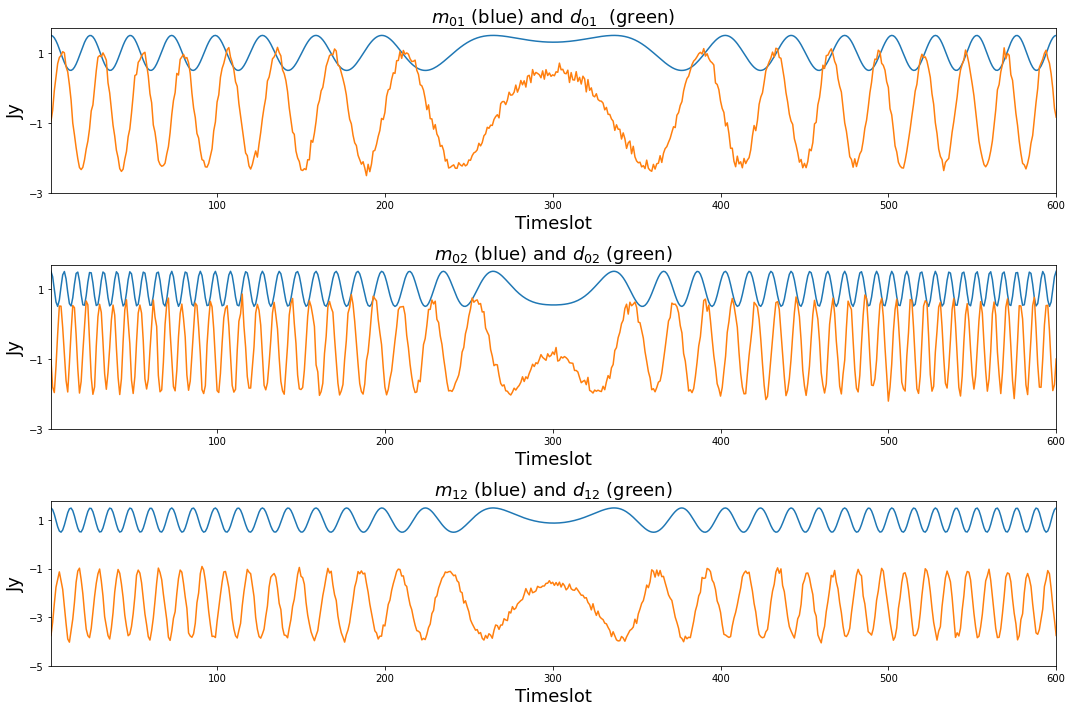

In [10]:
fig = plt.figure()

timeslots = np.cumsum(np.ones((len(M[0,1,:]),)))

#We only plot the real part of visibilities

#Plotting Baseline 01
ax = plt.subplot("311")
ax.set_title("$m_{01}$ (blue) and $d_{01}$  (green)", fontsize=18)
ax.plot(timeslots,M[0,1,:].real)
ax.plot(timeslots,D[0,1,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 02
ax = plt.subplot("312")
ax.set_title("$m_{02}$ (blue) and $d_{02}$ (green)", fontsize=18)
ax.plot(timeslots,M[0,2,:].real)
ax.plot(timeslots,D[0,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 12
ax = plt.subplot("313")
ax.set_title("$m_{12}$ (blue) and $d_{12}$ (green)", fontsize=18)
ax.plot(timeslots,M[1,2,:].real)
ax.plot(timeslots,D[1,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

plt.tight_layout()

plt.show()

**Figure 8.1.3**: <span style="background-color:cyan">AJR:NC: This figure needs a caption</span>

The images above contain the real part of the corrupted (green) and uncorrupted (blue)
visibilities as a function of timeslots for baseline 01, 02 and 12 respectively.

### 8.1.4 Levenberg-Marquardt (`create_G_LM`) <a id='cal:sec:LM'></a> <!--\label{cal:sec:LM}-->

We are now ready to use least squares to calibrate $\boldsymbol{\mathcal{D}}$ (see [<cite data-cite='Yatawatta2012'>GPU accelerated nonlinear optimization in radio interferometric calibration</cite> &#10548;](http://ieeexplore.ieee.org/xpl/freeabs_all.jsp?arnumber=6339610&abstractAccess=no&userType=inst)).

We first present a brief review of least squares minimization. Suppose we wish to fit a model $\mathbf{f}\left( \mathbf{m},\breve{\mathbf{g}}\right)$, where $\mathbf{m}$ and $\breve{\mathbf{g}}$ denote
the model input values and a vector of unknown variables respectively, to some data $\left\{\mathbf{d}_{i},\mathbf{m}_{i}\right\}$. The vector of unknown variables $\breve{\mathbf{g}}$ parametrize the model. A standard method for determining which parameter vector $\breve{\mathbf{g}}$ best fits the data is to minimize the sum of the squared residuals. This technique is referred to as least squares minimization. The residual vector is denoted by $\mathbf{r}(\mathbf{m},\mathbf{d},\breve{\mathbf{g}}) = \mathbf{d} - \mathbf{f}\left( \mathbf{m},\breve{\mathbf{g}}\right)$. The objective function (the function we wish to minimize) associated with least squares is: $\sum_i \mathbf{r}_i^2$. The function `optimize.leastsq` is `scipy`'s built-in least squares solver and employs the *Levenberg-Marquardt* algorithm in the background. The Levenberg-Marquardt algorithm is discussed in more detail in [$\S$ 2.11 &#10142;](../2_Mathematical_Groundwork/2_11_least_squares.ipynb). To use `optimize.leastsq` one needs a function, here called `err_func`, that calculates the residual vector $\mathbf{r}$. An initial guess of the parameter vector $\breve{\mathbf{g}}$ is also required.

For calibration the above variables become:

<p class=conclusion>
  <font size=4> <b>Vectorizing</b></font>
  <br>
  <br>
&bull; $\mathbf{d} = [\textrm{vec}(\Re\{\boldsymbol{\mathcal{D}}\}),\textrm{vec}(\Im\{\boldsymbol{\mathcal{D}}\})]$ <br><br>
&bull; $\mathbf{m} = [\textrm{vec}(\Re\{\boldsymbol{\mathcal{M}}\}),\textrm{vec}(\Im\{\boldsymbol{\mathcal{M}}\})]$ <br><br> 
&bull; $\breve{\mathbf{g}} = [\Re\{\mathbf{g}\},\Im\{\mathbf{g}\}]$ <br><br>
&bull; $\mathbf{f}\left(\mathbf{m},\breve{\mathbf{g}}\right) = [\textrm{vec}(\Re\{\boldsymbol{\mathcal{G}}\boldsymbol{\mathcal{M}}\boldsymbol{\mathcal{G}}^H\}),\textrm{vec}(\Im\{\boldsymbol{\mathcal{G}}\boldsymbol{\mathcal{M}}\boldsymbol{\mathcal{G}}^H\})]$, where
$\boldsymbol{\mathcal{M}} = \textrm{vec}^{-1}(\mathbf{m}_U)+\imath\textrm{vec}^{-1}(\mathbf{m}_L)$ and $\boldsymbol{\mathcal{G}} = \textrm{diag}(\breve{\mathbf{g}}_U)+\imath\textrm{diag}(\breve{\mathbf{g}}_L)$
</p>

In the above bullets $\textrm{vec}(\cdot)$, $\textrm{vec}^{-1}(\cdot)$, $(\cdot)_U$,
and $(\cdot)_L$ denote vectorization, matrization, the upper half of
a vector and the lower half of a vector respectively. Moreover, $\Re\{\cdot\}$ and $\Im\{\cdot\}$ denote the real and imaginary part of their operands.
The first thing we need to define in order to perform calibration by using `optimize.leastsq` is the function `err_func`, which we do below.

In [11]:
'''Unpolarized direction independent calibration entails finding the G that minimizes ||R-GMG^H||. 
This function evaluates D-GMG^H.
g is a vector containing the real and imaginary components of the antenna gains.
d is a vector containing a vecotrized R (observed visibilities), real and imaginary.
m is a vector containing a vecotrized M (predicted), real and imaginary.
r is a vector containing the residuals.
''' 
def err_func(g,d,m):
    Nm = len(d)//2
    N = len(g)//2
    G = np.diag(g[0:N]+1j*g[N:])
    D = np.reshape(d[0:Nm],(N,N))+np.reshape(d[Nm:],(N,N))*1j #matrization
    M = np.reshape(m[0:Nm],(N,N))+np.reshape(m[Nm:],(N,N))*1j
    T = np.dot(G,M)
    T = np.dot(T,G.conj())
    R = D - T
    r_r = np.ravel(R.real) #vectorization
    r_i = np.ravel(R.imag)
    r = np.hstack([r_r,r_i])
    return r

We are now able to define a wrapper function `create_G_LM` that in turn calls `optimize.leastsq`.
The wrapper function translates the calibration problem into a format that `optimize.leastsq`
can interpret. The input of `create_G_LM` is $\boldsymbol{\mathcal{D}}$ and $\boldsymbol{\mathcal{M}}$, while the output is $\mathbf{g}$ and $\boldsymbol{\mathscr{G}}=\mathbf{g}\mathbf{g}^H$.

In [12]:
'''This function finds argmin G ||D-GMG^H|| using Levenberg-Marquardt. It uses the optimize.leastsq scipy to perform
the actual minimization.
D is your observed visibilities matrx.
M is your predicted visibilities.
g the antenna gains.
G = gg^H.''' 
def create_G_LM(D,M):
    N = D.shape[0] #number of antennas
    temp =np.ones((D.shape[0],D.shape[1]) ,dtype=complex)
    G = np.zeros(D.shape,dtype=complex)
    g = np.zeros((D.shape[0],D.shape[2]),dtype=complex)
   
    for t in range(D.shape[2]): #perform calibration per time-slot
        g_0 = np.ones((2*N,)) # first antenna gain guess 
        g_0[N:] = 0
        d_r = np.ravel(D[:,:,t].real) #vectorization of observed + seperating real and imag
        d_i = np.ravel(D[:,:,t].imag)
        d = np.hstack([d_r,d_i])
        m_r = np.ravel(M[:,:,t].real) #vectorization of model + seperating real and imag
        m_i = np.ravel(M[:,:,t].imag)
        m = np.hstack([m_r,m_i])
        g_lstsqr_temp = optimize.leastsq(err_func, g_0, args=(d, m))
        g_lstsqr = g_lstsqr_temp[0]          
           
        G_m = np.dot(np.diag(g_lstsqr[0:N]+1j*g_lstsqr[N:]),temp)
        G_m = np.dot(G_m,np.diag((g_lstsqr[0:N]+1j*g_lstsqr[N:]).conj()))           

        g[:,t] = g_lstsqr[0:N]+1j*g_lstsqr[N:] #creating antenna gain vector       
        G[:,:,t] = G_m
         
    return g,G

We may now calibrate $\boldsymbol{\mathcal{D}}$ by using `create_G_LM`. 

In [13]:
glm,Glm = create_G_LM(D,M)

The above function works by vectorizing the real and imaginary part of $\boldsymbol{\mathcal{D}}$ and
storing the result in $\mathbf{d}$. The vector $\mathbf{m}$ is generated in a similar manner.
The error vector $\mathbf{r}$ is calculated by `err_func`. We initialize $\breve{\mathbf{g}}$ with
$\breve{\mathbf{g}}_0=[\mathbf{1},\mathbf{0}]$. We can then call 

`optimize.leastsq(self.err_func, g_0, args=(d, m))`.

We can now calculate $\mathbf{g} = \breve{\mathbf{g}}_U+\imath\breve{\mathbf{g}}_L$ and
$\boldsymbol{\mathscr{G}}=\mathbf{g}\mathbf{g}^H$. This is repeated for each observational time-slot.

### 8.1.5 Corrected Visibilites <a id='cal:sec:cor'></a> <!--\label{cal:sec:cor}-->

Before imaging, we have to correct our observed visibilities by removing the effect that the antenna gains had on the observed visibilities. This can be accomplished by using
<p class=conclusion>
  <font size=4> <b>Correcting Visibilities</b></font>
  <br>
\begin{equation}
 \boldsymbol{\mathcal{D}}^\mathrm{(c)} = \boldsymbol{\mathcal{G}}^{-1}\boldsymbol{\mathcal{D}}\boldsymbol{\mathcal{G}}^{-H} = \boldsymbol{\boldsymbol{\mathscr{G}}}^{\odot-1}\odot\boldsymbol{\mathcal{D}},
\end{equation}
</p><br>
where

* $\boldsymbol{\mathcal{D}}^\mathrm{(c)}$ is the *corrected visibility matrix*.
* $\boldsymbol{\mathscr{G}}^{\odot-1}$ denotes the *visibility calibration matrix*, which is computed by taking the Hadamard (element-wise) inverse of $\boldsymbol{\mathscr{G}}$.

The superscript $(\cdot)^{-1}$ denotes matrix inversion, while $(\cdot)^{-H}$ denotes the inverse of the Hermitian transpose. The operator $\odot$ denotes the Hadamard product. 
We calculate the corrected visibilities below.<br><br>

<div class=advice>
<b>Advice:</b> The matrix and vector operations (like $\odot$) and operators used in this section are discussed in more detail in [$\S$ 2.10 &#10142;](../2_Mathematical_Groundwork/2_10_linear_algebra.ipynb)
</div>

In [14]:
R_c = Glm**(-1)*D

We plot the corrected visibilities below. Note that the model and corrected visibilities align well, implying that calibration was successfull.

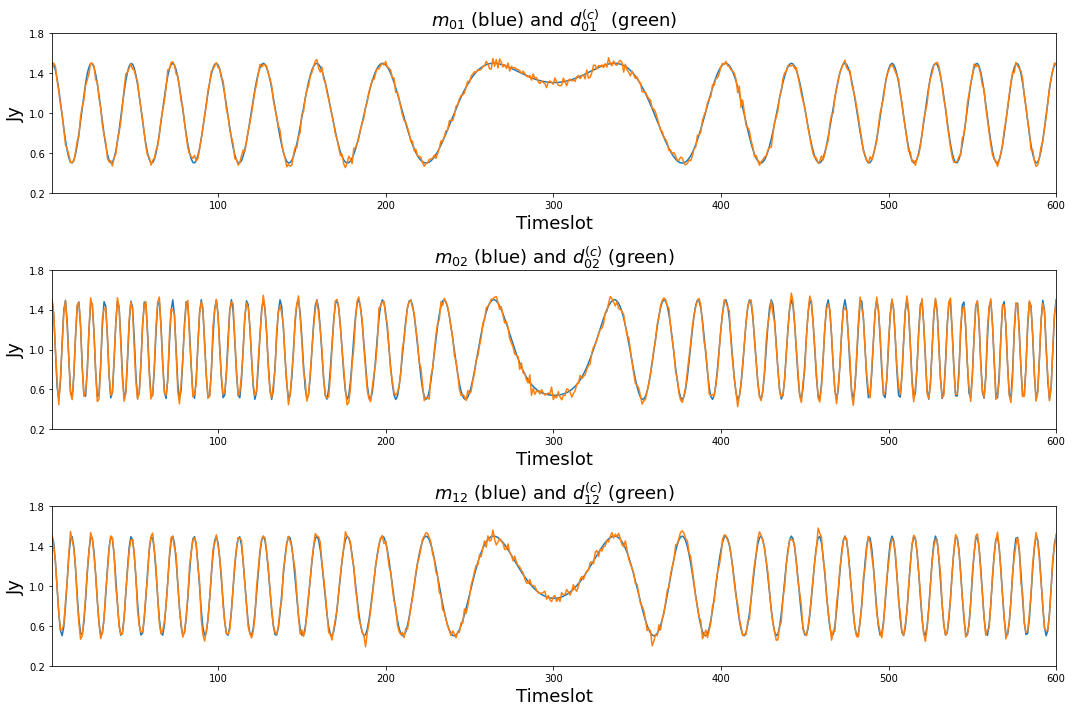

In [16]:
fig = plt.figure()

timeslots = np.cumsum(np.ones((len(M[0,1,:]),)))

#We only plot the real part of visibilities

#Plotting Baseline 01
ax = plt.subplot(311)
ax.set_title("$m_{01}$ (blue) and $d_{01}^{(c)}$  (green)", fontsize=18)
ax.plot(timeslots,M[0,1,:].real)
ax.plot(timeslots,R_c[0,1,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 02
ax = plt.subplot(312)
ax.set_title("$m_{02}$ (blue) and $d_{02}^{(c)}$ (green)", fontsize=18)
ax.plot(timeslots,M[0,2,:].real)
ax.plot(timeslots,R_c[0,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 12
ax = plt.subplot(313)
ax.set_title("$m_{12}$ (blue) and $d_{12}^{(c)}$ (green)", fontsize=18)
ax.plot(timeslots,M[1,2,:].real)
ax.plot(timeslots,R_c[1,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

plt.tight_layout()

plt.show()

**Figure 8.1.4**: <span style="background-color:cyan">AJR:NC: This figure needs a caption</span>

The images above contain the real part of the corrected (green) and uncorrupted (blue) visibilities as a function of time-slot for baseline 01, 02 and 12 respectively.

***

Next: [8.2 1GC calibration](8_2_1gc.ipynb)